In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, auc, r2_score, mean_squared_error
import shap

In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
try:
    project_root = Path.cwd().parent
    processed_path = project_root / "data" / "processed"
    
    df_full = pd.read_csv(processed_path / "features_clasificacion.csv")
    df_reg = pd.read_csv(processed_path / "features_regresion.csv")
    
    print("Datasets cargados exitosamente.")
    print(f"Forma del dataset de clasificación: {df_full.shape}")
    print(f"Forma del dataset de regresión: {df_reg.shape}")

except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. Verifica la ruta: {e}")
    df_full = None
    df_reg = None

Datasets cargados exitosamente.
Forma del dataset de clasificación: (30000, 46)
Forma del dataset de regresión: (30000, 29)



--- Iniciando Validación Cruzada para Clasificación ---
Logistic Regression: F1-Score Macro Promedio = 0.6483 (Desv. Est. = 0.0042)
Random Forest: F1-Score Macro Promedio = 0.6674 (Desv. Est. = 0.0028)


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:14:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:14:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:14:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site

XGBoost: F1-Score Macro Promedio = 0.6217 (Desv. Est. = 0.0079)

--- Optimizando Umbral para XGBoost ---


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Umbral óptimo encontrado: 0.7397

--- Reporte de Clasificación con Umbral por Defecto (0.5) ---
                   precision    recall  f1-score   support

No Incumplimiento       0.88      0.64      0.74      4673
   Incumplimiento       0.35      0.70      0.47      1327

         accuracy                           0.65      6000
        macro avg       0.62      0.67      0.61      6000
     weighted avg       0.77      0.65      0.68      6000


--- Reporte de Clasificación con Umbral Optimizado (0.74) ---
                   precision    recall  f1-score   support

No Incumplimiento       0.87      0.79      0.83      4673
   Incumplimiento       0.44      0.60      0.51      1327

         accuracy                           0.75      6000
        macro avg       0.66      0.69      0.67      6000
     weighted avg       0.78      0.75      0.76      6000


--- Análisis de Interpretabilidad con SHAP ---
Generando gráfico de resumen de SHAP...


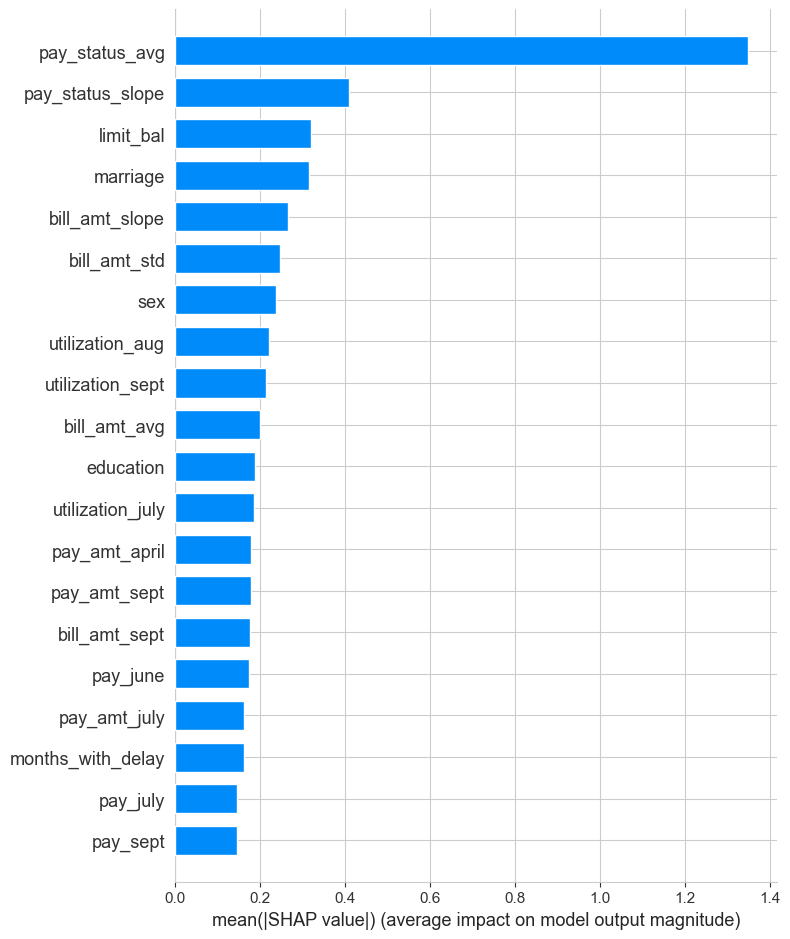

In [6]:
# Preparación de datos para clasificación
# CORRECCIÓN: Seleccionar solo columnas numéricas para evitar errores de conversión.
X = df_full.select_dtypes(include=np.number).drop(columns=['default_payment_next_month', 'ID'])
y = df_full['default_payment_next_month']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 1.1 Validación Cruzada con Pipelines y Muestreo Avanzado ---
print("\n--- Iniciando Validación Cruzada para Clasificación ---")
# Calcular scale_pos_weight para XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    pipeline = ImbPipeline([
        ('sampler', SMOTEENN(random_state=42)),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
    cv_results[name] = scores
    print(f"{name}: F1-Score Macro Promedio = {np.mean(scores):.4f} (Desv. Est. = {np.std(scores):.4f})")

# --- 1.2 Optimización de Umbral para el Mejor Modelo ---
print("\n--- Optimizando Umbral para XGBoost ---")
best_pipeline = ImbPipeline([
    ('sampler', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight))
])

best_pipeline.fit(X_train, y_train)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
# Se añade un pequeño épsilon para evitar la división por cero si precision y recall son cero
f1_scores = (2 * recall * precision) / (recall + precision + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Umbral óptimo encontrado: {optimal_threshold:.4f}")

print("\n--- Reporte de Clasificación con Umbral por Defecto (0.5) ---")
y_pred_default = (y_pred_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred_default, target_names=['No Incumplimiento', 'Incumplimiento']))

print(f"\n--- Reporte de Clasificación con Umbral Optimizado ({optimal_threshold:.2f}) ---")
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_optimal, target_names=['No Incumplimiento', 'Incumplimiento']))

# --- 1.3 Interpretabilidad del Modelo con SHAP ---
print("\n--- Análisis de Interpretabilidad con SHAP ---")
scaler = best_pipeline.named_steps['scaler']
model = best_pipeline.named_steps['classifier']
X_test_scaled = scaler.transform(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

print("Generando gráfico de resumen de SHAP...")
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)


In [9]:
# Preparación de datos para regresión
# CORRECCIÓN: Seleccionar solo columnas numéricas.
X_reg = df_reg.select_dtypes(include=np.number).drop(columns=['pay_amt_june', 'ID'])
y_reg = df_reg['pay_amt_june']

# 1. Creación del objetivo binario
y_hurdle_class = (y_reg > 0).astype(int)

# 2. Creación del subconjunto de datos para regresión (solo pagos > 0)
df_reg_pos = df_reg[df_reg['pay_amt_june'] > 0]
# CORRECCIÓN: Seleccionar solo columnas numéricas.
X_reg_pos = df_reg_pos.select_dtypes(include=np.number).drop(columns=['pay_amt_june', 'ID'])
y_reg_pos = df_reg_pos['pay_amt_june']

# División de datos
X_train_reg, X_test_reg, y_train_hurdle_class, y_test_hurdle_class, y_train_reg_orig, y_test_reg_orig = train_test_split(
    X_reg, y_hurdle_class, y_reg, test_size=0.2, random_state=42, stratify=y_hurdle_class
)
X_train_reg_pos, X_test_reg_pos, y_train_reg_pos, y_test_reg_pos = train_test_split(
    X_reg_pos, y_reg_pos, test_size=0.2, random_state=42
)

print(f"Datos para clasificación del obstáculo: {X_train_reg.shape[0]} entrenamiento, {X_test_reg.shape[0]} prueba")
print(f"Datos para regresión del monto: {X_train_reg_pos.shape[0]} entrenamiento, {X_test_reg_pos.shape[0]} prueba")

# --- 2.1 Entrenamiento del Modelo de Clasificación (Etapa 1) ---
scale_pos_weight_hurdle = y_train_hurdle_class.value_counts()[0] / y_train_hurdle_class.value_counts()[1]
pipeline_hurdle_class = ImbPipeline([
    ('sampler', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_hurdle))
])
pipeline_hurdle_class.fit(X_train_reg, y_train_hurdle_class)
y_pred_hurdle_class = pipeline_hurdle_class.predict(X_test_reg)

print("\n--- Rendimiento del Modelo de Clasificación del Obstáculo ---")
print(classification_report(y_test_hurdle_class, y_pred_hurdle_class, target_names=['No Paga', 'Sí Paga']))

# --- 2.2 Entrenamiento del Modelo de Regresión (Etapa 2) ---
# Winsorización del 1% superior de la variable objetivo
y_train_reg_pos_win = winsorize(y_train_reg_pos, limits=[0.0, 0.01])

pipeline_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Entrenamiento final
pipeline_reg.fit(X_train_reg_pos, y_train_reg_pos_win)
print("\n--- Modelo de Regresión (Etapa 2) entrenado. ---")

# --- 2.3 Combinación y Evaluación del Modelo de Obstáculo ---
# 1. Predecir si se realizará un pago
pred_paga_o_no = pipeline_hurdle_class.predict(X_test_reg)
# 2. Predecir el monto del pago para todos
pred_monto_si_paga = pipeline_reg.predict(X_test_reg)
# 3. Combinar las predicciones
final_predictions = pred_monto_si_paga * pred_paga_o_no

# 4. Evaluar contra los valores reales
r2_hurdle = r2_score(y_test_reg_orig, final_predictions)
rmse_hurdle = np.sqrt(mean_squared_error(y_test_reg_orig, final_predictions))

print("\n--- Evaluación Final del Modelo de Obstáculo Combinado ---")
print(f"R² Score: {r2_hurdle:.4f}")
print(f"RMSE: {rmse_hurdle:.4f}")

Datos para clasificación del obstáculo: 24000 entrenamiento, 6000 prueba
Datos para regresión del monto: 18873 entrenamiento, 4719 prueba


/opt/anaconda3/envs/riesgo_crediticio_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Rendimiento del Modelo de Clasificación del Obstáculo ---
              precision    recall  f1-score   support

     No Paga       0.78      0.96      0.86      1282
     Sí Paga       0.99      0.93      0.96      4718

    accuracy                           0.93      6000
   macro avg       0.88      0.94      0.91      6000
weighted avg       0.94      0.93      0.94      6000


--- Modelo de Regresión (Etapa 2) entrenado. ---

--- Evaluación Final del Modelo de Obstáculo Combinado ---
R² Score: 0.6357
RMSE: 9661.8764
